# Applied Machine Learning Homework 4

## Predicting wine quality from review texts and other properties of the wine
### https://www.kaggle.com/zynicide/wine-reviews

Due: Wed 04/22/20 1pm

Alberto Munguia Cisneros

UNI: am5334

## Task 1 Bag of Words and simple Features

# Table of Contents:<a class="anchor" id="0."></a>

1. [Bag of Words and simple Features](#1.)

    1.1 [Baseline Model, Non-text features](#1.1.)
    
    1.2 [Simple text-based linear model with BOW](#1.2.)
    
    1.3 [Tuned text-based linear model](#1.3.)
    
    1.4 [Combined linear model text and non-text features](#1.4.)
    


## 1.1 Baseline Model,  Non-text features <a class="anchor" id="1.1."></a>
[Back to Contents](#0.)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, ShuffleSplit, RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, RidgeCV
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder, LeaveOneOutEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
from sklearn.utils import shuffle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import Normalizer

from scipy.sparse import hstack

%matplotlib inline

### Export Data Base from csv and Get only US information

In [2]:
start_time = timeit.default_timer()

In [3]:
df=pd.read_csv('winemag-data-130k-v2.csv')
df_US = df[df.country=='US']
df_US = df_US.drop(columns=['Unnamed: 0'])

In [4]:
df_US.head(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
12,US,"Slightly reduced, this wine offers a chalky, t...",NaN,87,34.0,California,Alexander Valley,Sonoma,Virginie Boone,@vboone,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Cabernet Sauvignon,Louis M. Martini


In [5]:
df_US.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54504 entries, 2 to 129967
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                54504 non-null  object 
 1   description            54504 non-null  object 
 2   designation            36908 non-null  object 
 3   points                 54504 non-null  int64  
 4   price                  54265 non-null  float64
 5   province               54504 non-null  object 
 6   region_1               54226 non-null  object 
 7   region_2               50511 non-null  object 
 8   taster_name            37730 non-null  object 
 9   taster_twitter_handle  34741 non-null  object 
 10  title                  54504 non-null  object 
 11  variety                54504 non-null  object 
 12  winery                 54504 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.8+ MB


### Initial Exploratory Data Analysis

- **EDA target: Points**

In [6]:
df_US.points.describe()

count    54504.00000
mean        88.56372
std          3.11484
min         80.00000
25%         86.00000
50%         88.00000
75%         91.00000
max        100.00000
Name: points, dtype: float64

In [7]:
print(' # NA in {}: {:.0f}'.format((df_US.columns[3]), df_US.points.isna().sum()))

 # NA in points: 0


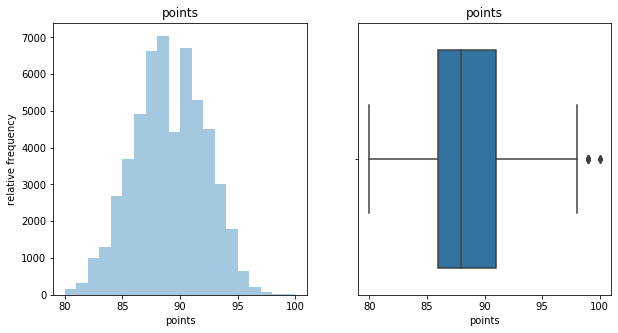

In [8]:
fig,ax = plt.subplots(1,2, figsize=(10,5))
sns.distplot(df_US.points,ax=ax[0], bins=20, kde=False);
sns.boxplot(df_US.points,ax=ax[1]);
ax[0].set_title("points");
ax[0].set_ylabel('relative frequency')
ax[1].set_title("points");

- **EDA continous features: Price**

In [9]:
cont = ['price']

In [10]:
df_US.price.describe()

count    54265.000000
mean        36.573464
std         27.088857
min          4.000000
25%         20.000000
50%         30.000000
75%         45.000000
max       2013.000000
Name: price, dtype: float64

In [11]:
print(' # NA in {}: {:.0f}'.format((df_US.columns[4]), df_US.price.isna().sum()))

 # NA in price: 239


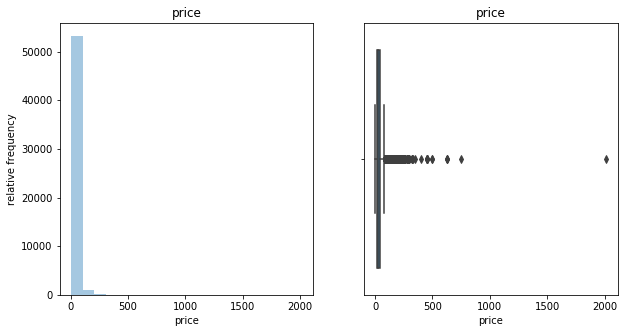

In [12]:
fig,ax = plt.subplots(1,2, figsize=(10,5))
sns.distplot(df_US.price,ax=ax[0], bins=20, kde=False);
sns.boxplot(df_US.price,ax=ax[1]);
ax[0].set_title("price");
ax[0].set_ylabel('relative frequency')
ax[1].set_title("price");

In [13]:
print('Quantile 0.9999: {:.1f}'.format(df_US.price.quantile(.9999)))
print('Number of wines 0.9999 quantile price: {:.0f}'.format(df_US.price[(df['price']>df_US.price.quantile(.9999))].count()))

Quantile 0.9999: 500.0
Number of wines 0.9999 quantile price: 5


Here we observe that this varaible has outliers that could be possible be ignored.

(80, 100)

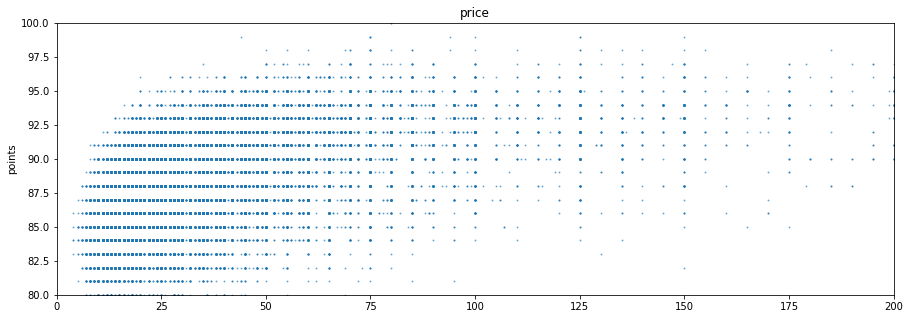

In [14]:
fig,ax = plt.subplots(1,1, figsize=(15,5))
ax.scatter(df_US.loc[:,cont[0]][~df_US.loc[:,cont[0]].isna()],df_US.points[~df_US.loc[:,cont[0]].isna()], 
           s=1, alpha=0.5)
ax.set_title(cont[0])
ax.set_ylabel('points')
ax.set_xlim(0,200)
ax.set_ylim(80,100)

In [15]:
df_US[['price','points']].corr(method='pearson')

,price,points
price,1.000000,0.453079
points,0.453079,1.000000


- **EDA categorical features: country, description, designation, province, region_1, region_2, taster_name, taster_twitter_handle, title, variety, winery**

In [16]:
categorical = df_US.dtypes == object
cat=df_US.loc[:, categorical].columns

In [17]:
df_US[cat].describe()

,country,description,designation,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
count,54504,54504,36908,54504,54226,50511,37730,34741,54504,54504,54504
unique,1,50449,14183,27,264,17,15,12,50229,257,5375
top,US,"Seductively tart in lemon pith, cranberry and ...",Reserve,California,Napa Valley,Central Coast,Virginie Boone,@vboone,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Pinot Noir,Testarossa
freq,54504,3,1485,36247,4480,11065,9537,9537,11,9885,218


In [18]:
for i in range(0,len(cat)):
    print('# NA in {}: {:.0f}'.format(cat[i],df_US.loc[:,cat[i]].isna().sum(), 100 * df_US.loc[:,cat[i]].isna().sum()/df_US.loc[:,cat[i]].count()))
    print('% NA in {}: {:.2f}'.format(cat[i],100 * df_US.loc[:,cat[i]].isna().sum()/df_US.loc[:,'price'].count()))

# NA in country: 0
% NA in country: 0.00
# NA in description: 0
% NA in description: 0.00
# NA in designation: 17596
% NA in designation: 32.43
# NA in province: 0
% NA in province: 0.00
# NA in region_1: 278
% NA in region_1: 0.51
# NA in region_2: 3993
% NA in region_2: 7.36
# NA in taster_name: 16774
% NA in taster_name: 30.91
# NA in taster_twitter_handle: 19763
% NA in taster_twitter_handle: 36.42
# NA in title: 0
% NA in title: 0.00
# NA in variety: 0
% NA in variety: 0.00
# NA in winery: 0
% NA in winery: 0.00


From the results above, we can infer that the principal text features in the data frame are **description, and title**, while,  **winery and designation** appear like categorical features with extremely high-cardinality (order of thousands) rather than text-features. Also, we have **province, taster_name,  taster_twitter_handle, and region_2** as low cardinality categorical features. And finally, we identify that **region_1 and variety** as high-cardinality features (order of hundreds).

In [19]:
txt_feat=['description', 'title']
non_txt_feat=['designation', 'price', 'province', 'region_1', 'region_2', 'taster_name', 
              'taster_twitter_handle', 'variety','winery']

cont=['price']
cat_exhigh=['designation', 'winery']
cat_high=['region_1', 'variety']
cat_low=['province', 'region_2', 'taster_name', 'taster_twitter_handle']

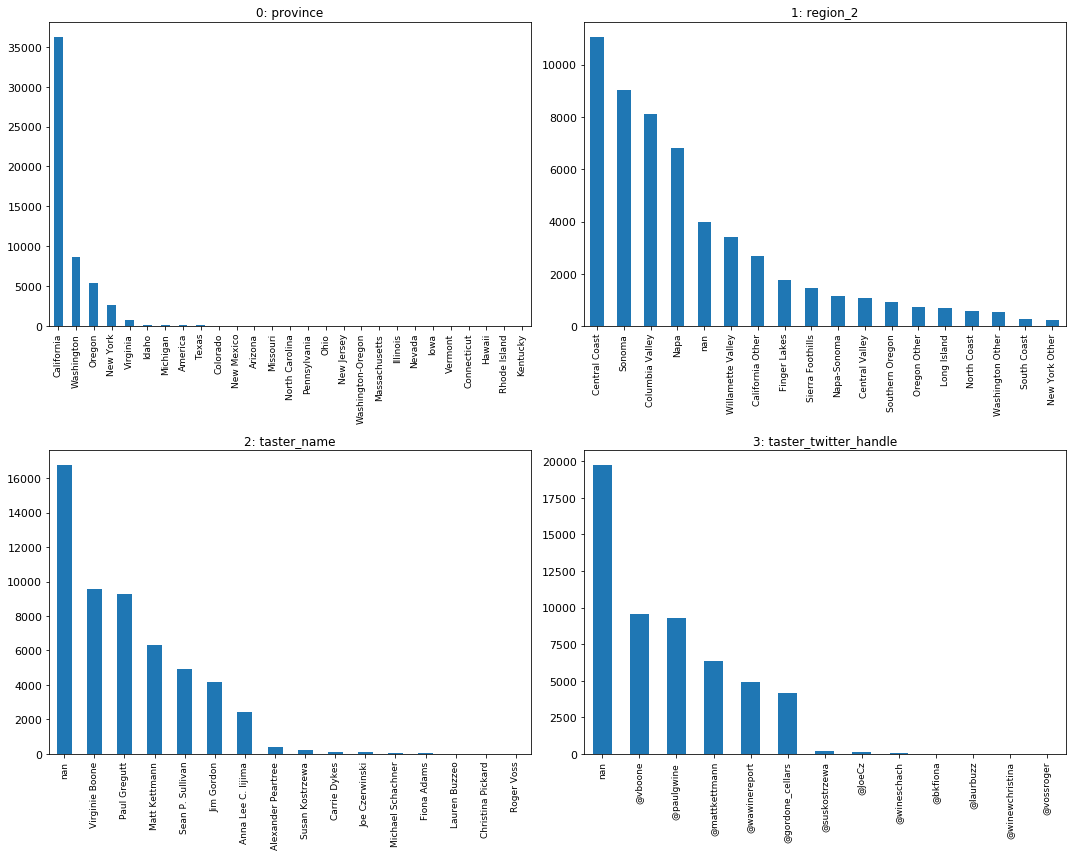

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(15,12))

for i, ax in enumerate(axes.ravel()):
    if i > 3:
        ax.set_visible(False)
        continue
    df_US.loc[:,cat_low[i]].value_counts(dropna=False).plot.bar(ax=ax);
    ax.set_title("{}: {}".format(i, cat_low[i]))
    ax.tick_params(axis='y', labelsize=11)
    ax.tick_params(axis='x', labelrotation=90, labelsize=9)
plt.tight_layout()

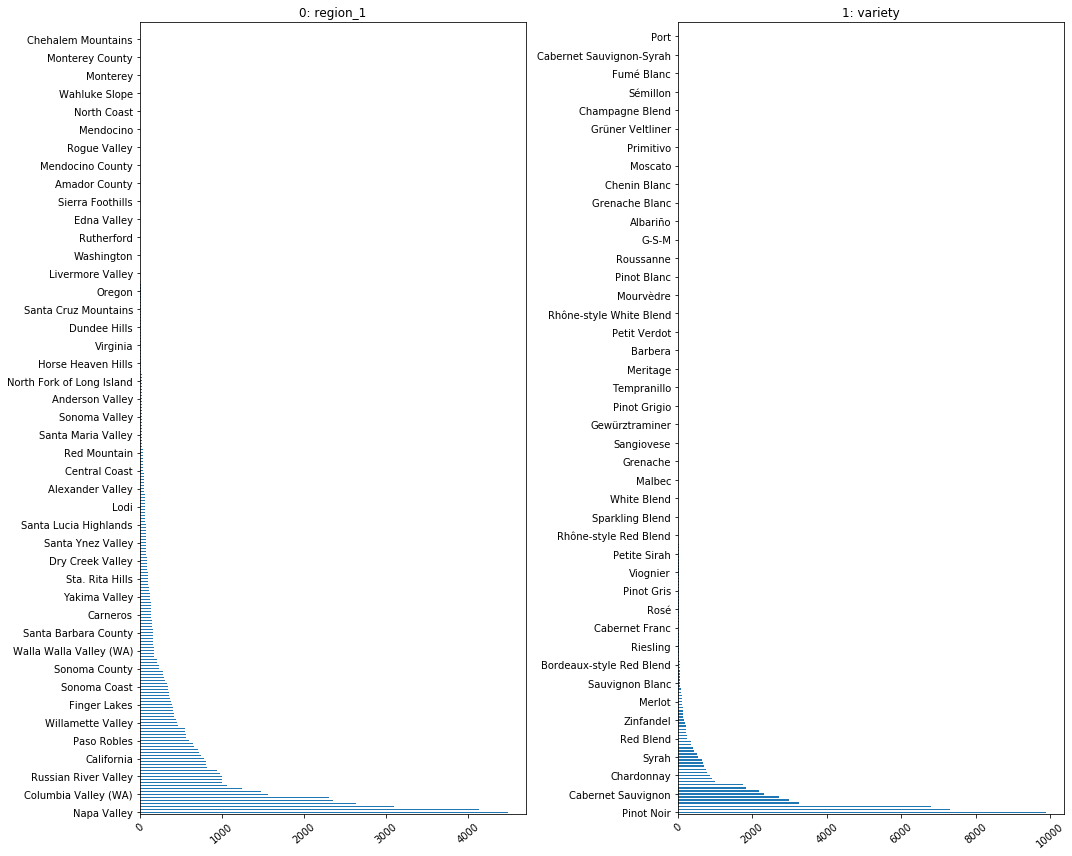

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(15,12))

for i, ax in enumerate(axes.ravel()):
    if i > 9:
        ax.set_visible(False)
        continue
    df_US.loc[:,cat_high[i]].value_counts().plot.barh(ax=ax);
    ax.set_title("{}: {}".format(i, cat_high[i]))
    ax.tick_params(axis='y', labelsize=10)
    ax.tick_params(axis='x', labelrotation=40)
    ax.locator_params(axis='y', nbins=50)

plt.tight_layout()

### Subsampling the data set

In [22]:
## Create a subsample
df_US_sub=df_US.sample(frac=.3, replace=False, random_state=7) # subsample of 0.3
df_US_sub.shape

(16351, 13)

In [23]:
## Create arrays y and X
y=df_US_sub['points']
#X=DF_sub[['year', 'odometer','condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive','size',
          #'type', 'paint_color','region', 'manufacturer', 'state']]
X=df_US_sub[['description', 'designation', 'points', 'price', 'province',
            'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
            'variety', 'winery']]

### Train and Test Split

In [24]:
quantile = list(y.quantile([0, 0.25, 0.5, 0.75, 1.0]))
y_binned = []
for points in y:
    if points<=quantile[1]:y_binned.append(1)
    elif points<=quantile[2]:y_binned.append(2)
    elif points<=quantile[3]:y_binned.append(3)
    else: y_binned.append(4)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y_binned)

### Choosing Linear Model Linear vs Ridge vs Lass vs ElasticNet

In [26]:
baseline_feat=['price', 'taster_name', 'variety', 'winery', 'region_1', 'region_2', 'designation']

In [27]:
cont_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_low_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Miss')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


cat_high_transformer = Pipeline(steps=[
    ('targetenc', TargetEncoder()),
    ('imputer', SimpleImputer(strategy='median'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('cont_tra', cont_transformer, ['price']),
        ('cat_low_tra', cat_low_transformer, ['taster_name', 'region_2']),
        ('cat_high_tra', cat_high_transformer, ['variety', 'winery', 'region_1', 'designation'])
    ], remainder = 'passthrough')
        

- **Linear Model**

In [28]:
ss = ShuffleSplit(n_splits=5)

reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('Regression', LinearRegression())])

res = cross_validate(reg, X_train.loc[:,baseline_feat] , y_train, scoring=['r2', 'neg_mean_squared_error','neg_mean_absolute_error',
                                                         'explained_variance'], return_train_score=False, cv=ss)
pd.DataFrame(res)

,fit_time,score_time,test_r2,test_neg_mean_squared_error,test_neg_mean_absolute_error,test_explained_variance
0,0.130924,0.020623,0.389825,-5.852329,-1.939710,0.389886
1,0.110009,0.015622,0.399091,-5.702624,-1.888123,0.399649
2,0.093729,0.015622,0.368597,-6.060598,-1.965507,0.369071
3,0.109346,0.015623,0.417388,-5.745755,-1.914279,0.419639
4,0.093730,0.015619,0.363617,-6.082811,-1.961867,0.363990


In [29]:
reg.fit(X_train.loc[:,baseline_feat] , y_train)
test_score = reg.score(X_test.loc[:,baseline_feat] , y_test)
print('Average R^2 in Cross_validation : {:.5f}'.format(res['test_r2'].mean()))
print('R^2 in the Test set : {:.5f}'.format(test_score))

Average R^2 in Cross_validation : 0.38770
R^2 in the Test set : 0.41206


- **Ridge**

In [30]:
ridge = Pipeline(steps=[('preprocessor', preprocessor),
                      ('Regression', Ridge())])

res = cross_validate(ridge, X_train.loc[:,baseline_feat] , y_train, scoring=['r2', 'neg_mean_squared_error','neg_mean_absolute_error',
                                                         'explained_variance'], return_train_score=False, cv=ss)
pd.DataFrame(res)

,fit_time,score_time,test_r2,test_neg_mean_squared_error,test_neg_mean_absolute_error,test_explained_variance
0,0.104750,0.015622,0.404707,-5.915673,-1.928514,0.405034
1,0.078133,0.015619,0.388492,-5.737406,-1.915116,0.388891
2,0.093742,0.000000,0.389978,-5.825122,-1.928503,0.389983
3,0.078106,0.015583,0.366092,-5.837939,-1.912374,0.366111
4,0.078142,0.015621,0.403995,-5.869242,-1.935062,0.404212


In [31]:
ridge.fit(X_train.loc[:,baseline_feat] , y_train)
test_score = ridge.score(X_test.loc[:,baseline_feat] , y_test)
print('Average R^2 in Cross_validation : {:.5f}'.format(res['test_r2'].mean()))
print('R^2 in the Test set : {:.5f}'.format(test_score))

Average R^2 in Cross_validation : 0.39065
R^2 in the Test set : 0.41175


- **Lasso**

In [32]:
lasso = Pipeline(steps=[('preprocessor', preprocessor),
                      ('Regression', Lasso())])

res = cross_validate(lasso, X_train.loc[:,baseline_feat] , y_train, scoring=['r2', 'neg_mean_squared_error','neg_mean_absolute_error',
                                                         'explained_variance'], return_train_score=False, cv=ss)
pd.DataFrame(res)

,fit_time,score_time,test_r2,test_neg_mean_squared_error,test_neg_mean_absolute_error,test_explained_variance
0,0.100418,0.000000,0.205377,-7.395576,-2.153069,0.207621
1,0.093729,0.015620,0.239271,-7.391724,-2.183805,0.239290
2,0.093729,0.000000,0.233084,-7.614084,-2.218130,0.233490
3,0.093729,0.015620,0.201236,-7.353783,-2.180114,0.202306
4,0.078107,0.015621,0.264109,-7.082984,-2.119071,0.267490


In [33]:
lasso.fit(X_train.loc[:,baseline_feat] , y_train)
test_score = lasso.score(X_test.loc[:,baseline_feat] , y_test)
print('Average R^2 in Cross_validation : {:.5f}'.format(res['test_r2'].mean()))
print('R^2 in the Test set : {:.5f}'.format(test_score))

Average R^2 in Cross_validation : 0.22862
R^2 in the Test set : 0.25351


- **Elastic Net**

In [34]:
elastic = Pipeline(steps=[('preprocessor', preprocessor),
                      ('Regression', ElasticNet())])

res = cross_validate(elastic, X_train.loc[:,baseline_feat] , y_train, scoring=['r2', 'neg_mean_squared_error','neg_mean_absolute_error',
                                                         'explained_variance'], return_train_score=False, cv=ss)
pd.DataFrame(res)

,fit_time,score_time,test_r2,test_neg_mean_squared_error,test_neg_mean_absolute_error,test_explained_variance
0,0.111453,0.015586,0.290114,-6.998527,-2.138263,0.290261
1,0.109352,0.015620,0.272050,-7.197423,-2.163822,0.272269
2,0.078105,0.015621,0.273966,-7.447858,-2.187081,0.274574
3,0.093729,0.015620,0.284029,-6.516162,-2.069722,0.284053
4,0.093729,0.000000,0.262856,-7.487263,-2.187640,0.263116


In [35]:
elastic.fit(X_train.loc[:,baseline_feat] , y_train)
test_score = elastic.score(X_test.loc[:,baseline_feat] , y_test)
print('Average R^2 in Cross_validation : {:.5f}'.format(res['test_r2'].mean()))
print('R^2 in the Test set : {:.5f}'.format(test_score))

Average R^2 in Cross_validation : 0.27660
R^2 in the Test set : 0.30171


**From the results above we can conclude that the Ridge regression gives us the best performance among the lienar procedures that we have tested**

### Tunning Ridge 

In [36]:
ridge_pipeline = make_pipeline(preprocessor, Ridge(max_iter=5000))
ridge_param_grid = {'ridge__alpha': np.logspace(-4, 5, 20)}
ridge_gcv = GridSearchCV(ridge_pipeline, param_grid=ridge_param_grid, cv=ss, return_train_score=True)
ridge_gcv.fit(X_train.loc[:,baseline_feat] , y_train)
print('Ridge best parameters: {}'.format(ridge_gcv.best_params_))
print('Ridge best R^2: {:.5f}'.format(ridge_gcv.best_score_))

Ridge best parameters: {'ridge__alpha': 0.00029763514416313193}
Ridge best R^2: 0.39978


In [37]:
test_accuray_ridge = ridge_gcv.best_estimator_.score(X_test.loc[:,baseline_feat] , y_test)
print('R^2 in the Test set : {:.5f}'.format(test_accuray_ridge))

R^2 in the Test set : 0.41179


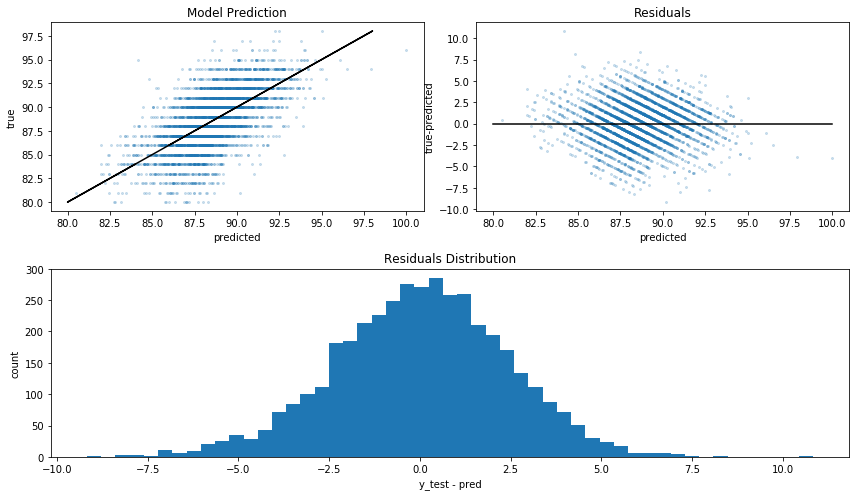

In [38]:
pred = ridge_gcv.best_estimator_.predict(X_test.loc[:,baseline_feat])

plt.figure(figsize=(12,7))
ax11 = plt.subplot(2, 2, 1)
ax12 = plt.subplot(2, 2, 2)
ax2 = plt.subplot(2, 1, 2)

ax11.scatter(pred, y_test, alpha=0.2, s=4)
ax11.plot(y_test, y_test, '-', c='k')
ax11.set_title("Model Prediction")
ax11.set_ylabel('true')
ax11.set_xlabel('predicted')

ax12.scatter(pred, (y_test-pred), alpha=0.2, s=4)
ax12.plot([80, 100], [0, 0], '-', c='k')
ax12.set_title("Residuals")
ax12.set_ylabel('true-predicted')
ax12.set_xlabel('predicted')

ax2.hist(y_test - pred, bins="auto")
ax2.set_title("Residuals Distribution")
ax2.set_xlabel("y_test - pred")
ax2.set_ylabel("count")

plt.tight_layout()

**Tunning the Ridge regression for the non-text features leads to a marginal improve in the $R^2$ metric**

## 1.2 Simple text-based linear model with BOW <a class="anchor" id="1.2."></a>
[Back to Contents](#0.)


- **Initial Model fot with Ridge**

In [39]:
vect = CountVectorizer()
X_train_BOW_des=vect.fit_transform(X_train.description[:])
X_test_BOW_des=vect.transform(X_test.description[:])
feature_names_des = vect.get_feature_names()

In [40]:
X_train_BOW_title = vect.fit_transform(X_train.title[:])
X_test_BOW_title = vect.transform(X_test.title[:])
feature_names_title = vect.get_feature_names()

In [41]:
feature_names_txt = np.concatenate((feature_names_des, feature_names_title))

In [42]:
X_train_BOW_txt = hstack((X_train_BOW_des, X_train_BOW_title))
X_test_BOW_txt = hstack((X_test_BOW_des, X_test_BOW_title))

In [43]:
ridge = Ridge()

res = cross_validate(ridge, X_train_BOW_txt , y_train, scoring=['r2', 'neg_mean_squared_error','neg_mean_absolute_error',
                                                         'explained_variance'], return_train_score=False, cv=ss)
pd.DataFrame(res)

,fit_time,score_time,test_r2,test_neg_mean_squared_error,test_neg_mean_absolute_error,test_explained_variance
0,0.365737,0.0,0.638873,-3.418597,-1.438628,0.639972
1,0.359291,0.0,0.590476,-3.698120,-1.495087,0.590866
2,0.428404,0.0,0.621850,-3.487003,-1.439906,0.623050
3,0.468556,0.0,0.640354,-3.742583,-1.511851,0.640388
4,0.468640,0.0,0.624315,-3.696446,-1.506946,0.624357


In [44]:
ridge.fit(X_train_BOW_txt , y_train)
test_score = ridge.score(X_test_BOW_txt , y_test)
print('Average R^2 in Cross_validation : {:.5f}'.format(res['test_r2'].mean()))
print('R^2 in the Test set : {:.5f}'.format(test_score))

Average R^2 in Cross_validation : 0.62317
R^2 in the Test set : 0.66229


- **Grid-Search and CV**

In [45]:
ridge = Ridge(max_iter=5000)

ridge_param_grid = {'alpha': np.logspace(-4, 5, 20) }
ridge_gcv = GridSearchCV(ridge, param_grid = ridge_param_grid ,cv=ss, return_train_score=True)
ridge_gcv.fit(X_train_BOW_txt , y_train)
print('Ridge best parameters: {}'.format(ridge_gcv.best_params_))
print('Ridge best R^2: {:.5f}'.format(ridge_gcv.best_score_))

Ridge best parameters: {'alpha': 16.23776739188721}
Ridge best R^2: 0.71951


In [46]:
test_accuray_ridge = ridge_gcv.best_estimator_.score(X_test_BOW_txt , y_test)
print('R^2 in the Test set : {:.5f}'.format(test_accuray_ridge))

R^2 in the Test set : 0.73917


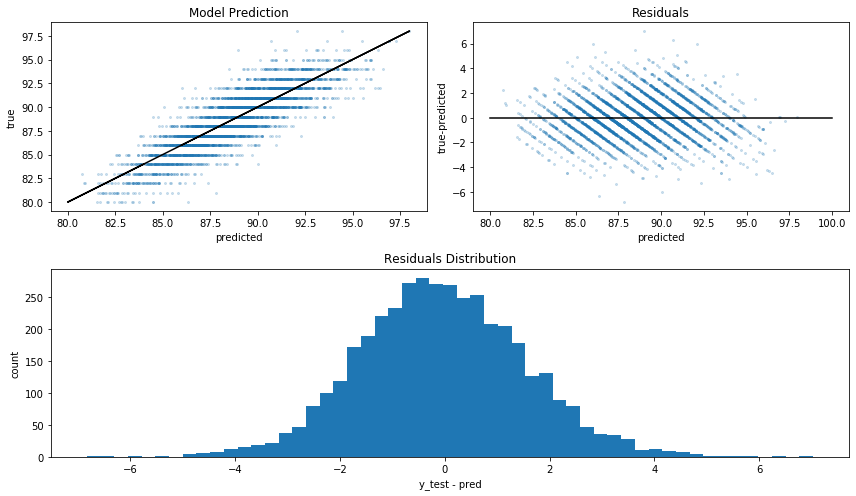

In [47]:
pred = ridge_gcv.best_estimator_.predict(X_test_BOW_txt)

plt.figure(figsize=(12,7))
ax11 = plt.subplot(2, 2, 1)
ax12 = plt.subplot(2, 2, 2)
ax2 = plt.subplot(2, 1, 2)

ax11.scatter(pred, y_test, alpha=0.2, s=4)
ax11.plot(y_test, y_test, '-', c='k')
ax11.set_title("Model Prediction")
ax11.set_ylabel('true')
ax11.set_xlabel('predicted')

ax12.scatter(pred, (y_test-pred), alpha=0.2, s=4)
ax12.plot([80, 100], [0, 0], '-', c='k')
ax12.set_title("Residuals")
ax12.set_ylabel('true-predicted')
ax12.set_xlabel('predicted')

ax2.hist(y_test - pred, bins="auto")
ax2.set_title("Residuals Distribution")
ax2.set_xlabel("y_test - pred")
ax2.set_ylabel("count")

plt.tight_layout()

In [48]:
def plot_important_features(coef, feature_names, top_n=20, ax=None, rotation=60):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    colors = ['red'] * top_n + ['blue'] * top_n
    
    ax.bar(myrange, coef[important], color=colors)
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=rotation, ha="right")
    ax.set_xlim(-.7, 2 * top_n)
    ax.set_frame_on(False)

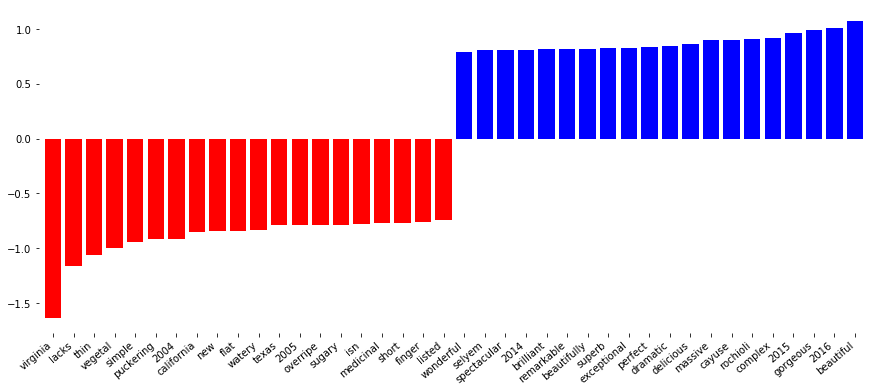

In [49]:
plt.figure(figsize=(15, 6))
plot_important_features(ridge_gcv.best_estimator_.coef_.ravel(), np.array(feature_names_txt), top_n=20, rotation=40)
ax = plt.gca()

**From this first model with text features, using BOW, we can observe a significant improvement in the $R^2$, we have obtained 0.739 in the grid-search version of the Ridge regression.**

**Furthermore, if we observe the highest coefficients associated with representative words, we observe that adjectives like beautiful, gorgeous, thin are explicative of the price of the wine. Also, we observe that the year of the vintage is important for example 2014, 2015, 2016.**

## 1.3 Tuned text-based linear model <a class="anchor" id="1.3."></a>
[Back to Contents](#0.)

### N-grams, Stopwords and Minimum Frequency with CountVectorizer

- **Grid-Search on N-grams and Minimum Frequency with Best Previous Ridge Best Parameter**

In [50]:
X_train_concat=X_train.description[:] + X_train.title[:]
X_test_concat=X_test.description[:] + X_test.title[:]

In [51]:
%%time
param_grid = {'countvectorizer__ngram_range': [(1, 1), (1, 2), (1,3)], 
              'countvectorizer__min_df': [1, 2, 3, 4]}


pipeline = make_pipeline(CountVectorizer(stop_words="english"), Ridge(alpha=1.62377674e+01, max_iter=5000))
ridge_gcv = GridSearchCV(pipeline, param_grid=param_grid, cv=ss, return_train_score=True)
ridge_gcv.fit(X_train_concat, y_train)
print('Ridge best parameters: {}'.format(ridge_gcv.best_params_))
print('Ridge best R^2: {:.5f}'.format(ridge_gcv.best_score_))

Ridge best parameters: {'countvectorizer__min_df': 1, 'countvectorizer__ngram_range': (1, 2)}
Ridge best R^2: 0.71116
Wall time: 2min 8s


In [52]:
test_accuray_ridge = ridge_gcv.best_estimator_.score(X_test_concat , y_test)
print('R^2 in the Test set : {:.5f}'.format(test_accuray_ridge))

R^2 in the Test set : 0.73017


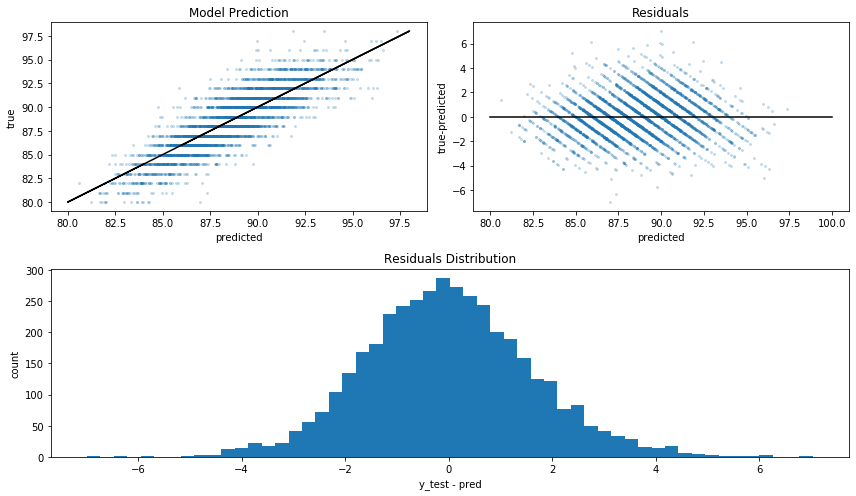

In [53]:
pred = ridge_gcv.best_estimator_.predict(X_test_concat)

plt.figure(figsize=(12,7))
ax11 = plt.subplot(2, 2, 1)
ax12 = plt.subplot(2, 2, 2)
ax2 = plt.subplot(2, 1, 2)

ax11.scatter(pred, y_test, alpha=0.2, s=4)
ax11.plot(y_test, y_test, '-', c='k')
ax11.set_title("Model Prediction")
ax11.set_ylabel('true')
ax11.set_xlabel('predicted')

ax12.scatter(pred, (y_test-pred), alpha=0.2, s=4)
ax12.plot([80, 100], [0, 0], '-', c='k')
ax12.set_title("Residuals")
ax12.set_ylabel('true-predicted')
ax12.set_xlabel('predicted')

ax2.hist(y_test - pred, bins="auto")
ax2.set_title("Residuals Distribution")
ax2.set_xlabel("y_test - pred")
ax2.set_ylabel("count")

plt.tight_layout()

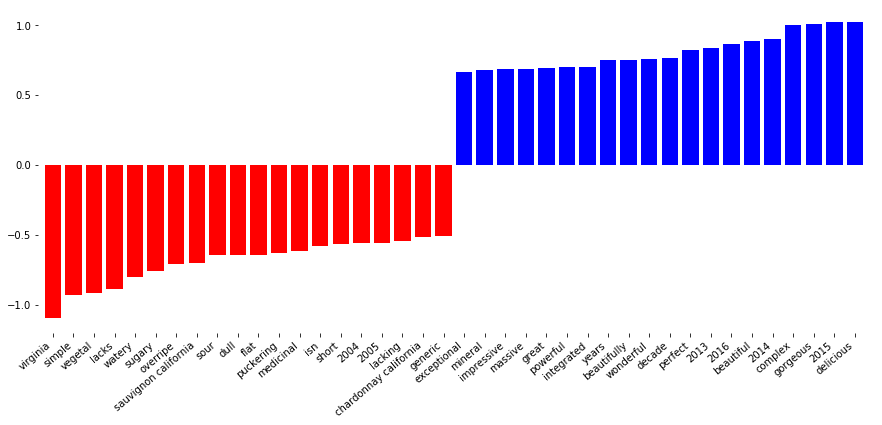

In [54]:
plt.figure(figsize=(15, 6))
feature_names_txt = np.array(ridge_gcv.best_estimator_.named_steps['countvectorizer'].get_feature_names())
plot_important_features(ridge_gcv.best_estimator_.named_steps['ridge'].coef_.ravel(), np.array(feature_names_txt), top_n=20, rotation=40)
ax = plt.gca()

- **Grid-Search on Ridge with best previous N-grams and Minimum Frequency**

In [55]:
X_train_concat=X_train.description[:] + X_train.title[:]
X_test_concat=X_test.description[:] + X_test.title[:]

In [56]:
%%time
param_grid = {'ridge__alpha': np.logspace(-4, 5, 20)}

pipeline = make_pipeline(CountVectorizer(ngram_range=(1, 2), min_df=1, stop_words="english"), Ridge(max_iter=5000))
ridge_gcv = GridSearchCV(pipeline, param_grid=param_grid, cv=ss, return_train_score=True)
ridge_gcv.fit(X_train_concat, y_train)
print('Ridge best parameters: {}'.format(ridge_gcv.best_params_))
print('Ridge best R^2: {:.5f}'.format(ridge_gcv.best_score_))

Ridge best parameters: {'ridge__alpha': 5.455594781168514}
Ridge best R^2: 0.70428
Wall time: 3min 38s


In [57]:
test_accuray_ridge = ridge_gcv.best_estimator_.score(X_test_concat , y_test)
print('R^2 in the Test set : {:.5f}'.format(test_accuray_ridge))

R^2 in the Test set : 0.73033


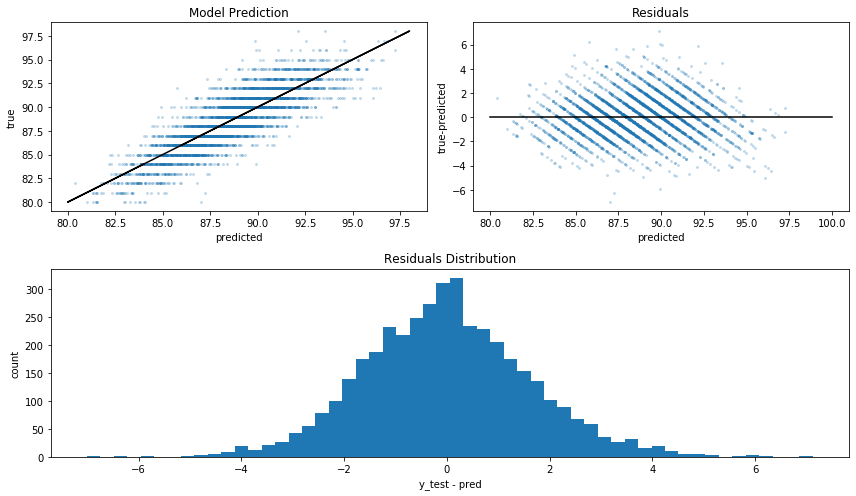

In [58]:
pred = ridge_gcv.best_estimator_.predict(X_test_concat)

plt.figure(figsize=(12,7))
ax11 = plt.subplot(2, 2, 1)
ax12 = plt.subplot(2, 2, 2)
ax2 = plt.subplot(2, 1, 2)

ax11.scatter(pred, y_test, alpha=0.2, s=4)
ax11.plot(y_test, y_test, '-', c='k')
ax11.set_title("Model Prediction")
ax11.set_ylabel('true')
ax11.set_xlabel('predicted')

ax12.scatter(pred, (y_test-pred), alpha=0.2, s=4)
ax12.plot([80, 100], [0, 0], '-', c='k')
ax12.set_title("Residuals")
ax12.set_ylabel('true-predicted')
ax12.set_xlabel('predicted')

ax2.hist(y_test - pred, bins="auto")
ax2.set_title("Residuals Distribution")
ax2.set_xlabel("y_test - pred")
ax2.set_ylabel("count")

plt.tight_layout()

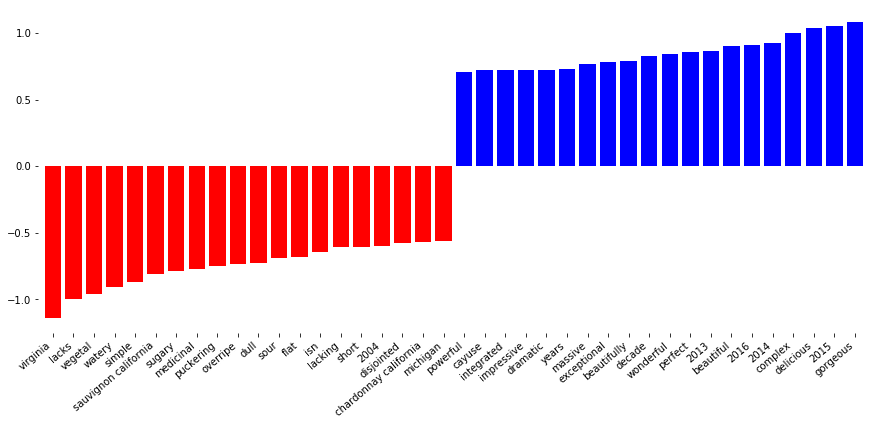

In [59]:
plt.figure(figsize=(15, 6))
feature_names_txt = np.array(ridge_gcv.best_estimator_.named_steps['countvectorizer'].get_feature_names())
plot_important_features(ridge_gcv.best_estimator_.named_steps['ridge'].coef_.ravel(), np.array(feature_names_txt), top_n=20, rotation=40)
ax = plt.gca()

**This tunned model on,  parameters n-grams and minimum frequency, has similar results than our initial BOW in terms of $R^2$. By using n-grams (1,2) we observe that within the best coefficients, compound words of the wine origin stand out, for example, sauvignon California, or chardonnay California. However, the most important text features are dominated by adjectives.**


### N-grams, Stopwords and Minimum Frequency with TfidfVectorizer

- **Grid-Search on N-grams and Minimum Frequency with Best Previous Ridge Best Parameter**

In [60]:
X_train_concat=X_train.description[:] + X_train.title[:]
X_test_concat=X_test.description[:] + X_test.title[:]

In [61]:
%%time
param_grid = {'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1,3)], 
              'tfidfvectorizer__min_df': [1, 2, 3, 4]}


pipeline = make_pipeline(TfidfVectorizer(stop_words="english"), Ridge(alpha=5.455594781168514, max_iter=5000))
ridge_gcv = GridSearchCV(pipeline, param_grid=param_grid, cv=ss, return_train_score=True)
ridge_gcv.fit(X_train_concat, y_train)
print('Ridge best parameters: {}'.format(ridge_gcv.best_params_))
print('Ridge best R^2: {:.5f}'.format(ridge_gcv.best_score_))

Ridge best parameters: {'tfidfvectorizer__min_df': 4, 'tfidfvectorizer__ngram_range': (1, 1)}
Ridge best R^2: 0.60806
Wall time: 1min 54s


In [62]:
test_accuray_ridge = ridge_gcv.best_estimator_.score(X_test_concat , y_test)
print('R^2 in the Test set : {:.5f}'.format(test_accuray_ridge))

R^2 in the Test set : 0.64112


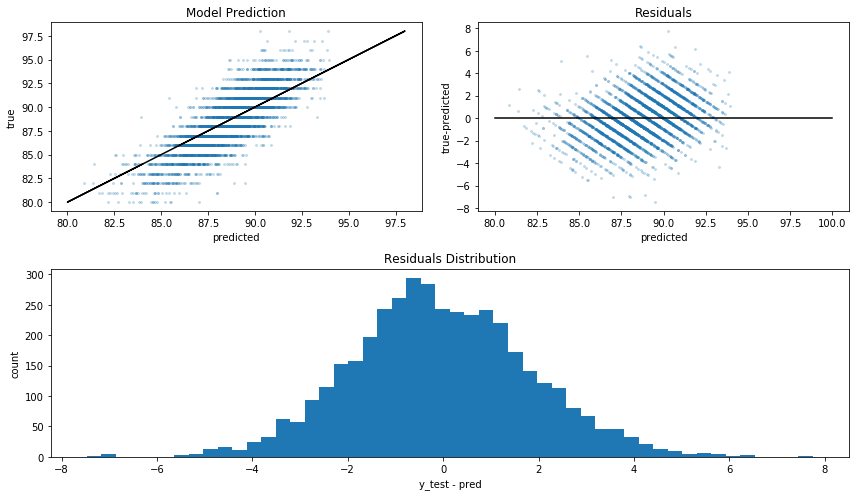

In [63]:
pred = ridge_gcv.best_estimator_.predict(X_test_concat)

plt.figure(figsize=(12,7))
ax11 = plt.subplot(2, 2, 1)
ax12 = plt.subplot(2, 2, 2)
ax2 = plt.subplot(2, 1, 2)

ax11.scatter(pred, y_test, alpha=0.2, s=4)
ax11.plot(y_test, y_test, '-', c='k')
ax11.set_title("Model Prediction")
ax11.set_ylabel('true')
ax11.set_xlabel('predicted')

ax12.scatter(pred, (y_test-pred), alpha=0.2, s=4)
ax12.plot([80, 100], [0, 0], '-', c='k')
ax12.set_title("Residuals")
ax12.set_ylabel('true-predicted')
ax12.set_xlabel('predicted')

ax2.hist(y_test - pred, bins="auto")
ax2.set_title("Residuals Distribution")
ax2.set_xlabel("y_test - pred")
ax2.set_ylabel("count")

plt.tight_layout()

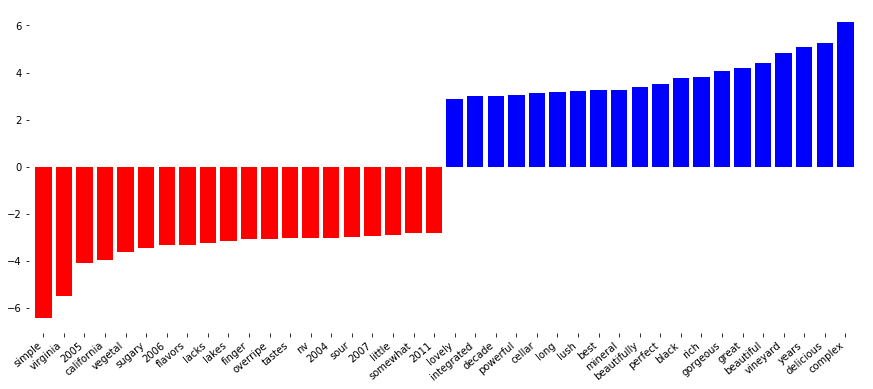

In [64]:
plt.figure(figsize=(15, 6))
feature_names_txt = np.array(ridge_gcv.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names())
plot_important_features(ridge_gcv.best_estimator_.named_steps['ridge'].coef_.ravel(), np.array(feature_names_txt), top_n=20, rotation=40)
ax = plt.gca()

- **Grid-Search on Ridge with best previous N-grams and Minimum Frequency**

In [65]:
X_train_concat=X_train.description[:] + X_train.title[:]
X_test_concat=X_test.description[:] + X_test.title[:]

In [66]:
%%time
param_grid = {'ridge__alpha': np.logspace(-4, 5, 20)}

pipeline = make_pipeline(TfidfVectorizer(ngram_range=(1, 1), min_df=4, stop_words="english"), Ridge(max_iter=5000))
ridge_gcv = GridSearchCV(pipeline, param_grid=param_grid, cv=ss, return_train_score=True)
ridge_gcv.fit(X_train_concat, y_train)
print('Ridge best parameters: {}'.format(ridge_gcv.best_params_))
print('Ridge best R^2: {:.5f}'.format(ridge_gcv.best_score_))

Ridge best parameters: {'ridge__alpha': 0.615848211066026}
Ridge best R^2: 0.67653
Wall time: 1min 26s


In [67]:
test_accuray_ridge = ridge_gcv.best_estimator_.score(X_test_concat , y_test)
print('R^2 in the Test set : {:.5f}'.format(test_accuray_ridge))

R^2 in the Test set : 0.69877


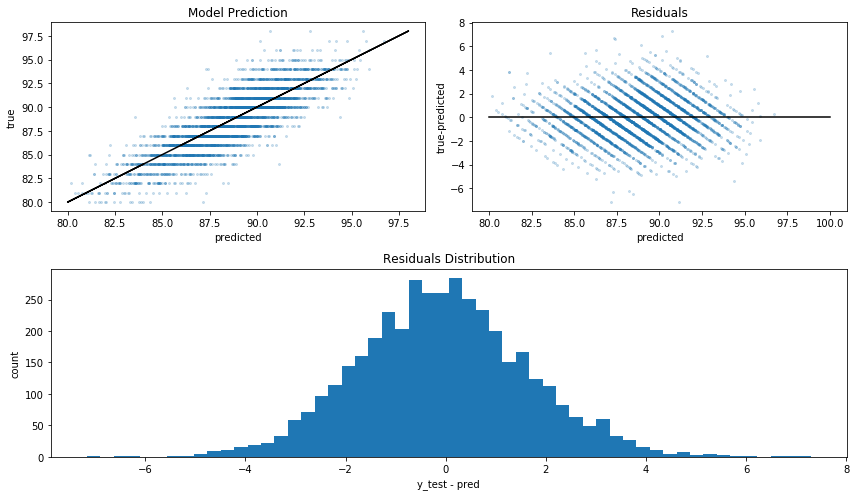

In [68]:
pred = ridge_gcv.best_estimator_.predict(X_test_concat)

plt.figure(figsize=(12,7))
ax11 = plt.subplot(2, 2, 1)
ax12 = plt.subplot(2, 2, 2)
ax2 = plt.subplot(2, 1, 2)

ax11.scatter(pred, y_test, alpha=0.2, s=4)
ax11.plot(y_test, y_test, '-', c='k')
ax11.set_title("Model Prediction")
ax11.set_ylabel('true')
ax11.set_xlabel('predicted')

ax12.scatter(pred, (y_test-pred), alpha=0.2, s=4)
ax12.plot([80, 100], [0, 0], '-', c='k')
ax12.set_title("Residuals")
ax12.set_ylabel('true-predicted')
ax12.set_xlabel('predicted')

ax2.hist(y_test - pred, bins="auto")
ax2.set_title("Residuals Distribution")
ax2.set_xlabel("y_test - pred")
ax2.set_ylabel("count")

plt.tight_layout()

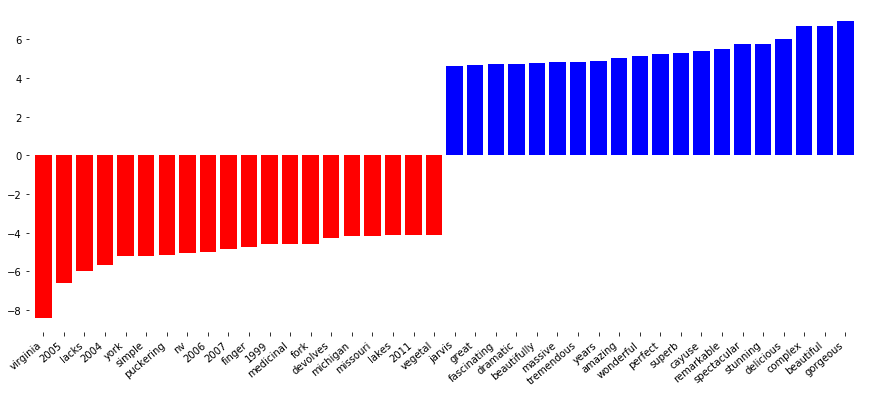

In [69]:
plt.figure(figsize=(15, 6))
feature_names_txt = np.array(ridge_gcv.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names())
plot_important_features(ridge_gcv.best_estimator_.named_steps['ridge'].coef_.ravel(), np.array(feature_names_txt), top_n=20, rotation=40)
ax = plt.gca()

**In terms of $R^2$ the models using Tfidf have an inferior performance that our models using counvectorizer, the most important features differ from the ones observed in our previous results. For example, the vintages associated with higher prices disappear, and on the contrary vintages like 1999, 2011 and 2006 appear in the coefficients associated to low prices**

In [70]:
del df, df_US, df_US_sub, X_test_BOW_des, X_test_BOW_title, X_train_BOW_des, X_train_BOW_title, X_test_BOW_txt, X_train_BOW_txt

## 1.4 Combined linear model text and non-text features <a class="anchor" id="1.4."></a>
[Back to Contents](#0.)

### Previous preprocessing and Non Tunned Fitting

In [71]:
## Create an alternative X_train and X_test whith the selected values for non-text features 
#and a concatenated version of the varibles description and title

selected_feat=['price', 'taster_name', 'variety', 'winery', 'region_1', 'region_2', 'designation', 'description', 'title']

X_train_s = X_train.loc[:,selected_feat]
X_test_s = X_test.loc[:,selected_feat]

X_train_s['txt'] = X_train_s.description[:] + X_train_s.title[:]
X_test_s['txt'] = X_test_s.description[:] + X_test_s.title[:]


X_train_s = X_train_s.drop(columns=['description', 'title'])
X_test_s = X_test_s.drop(columns=['description', 'title'])


In [72]:
cont_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_low_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Miss')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

cat_high_transformer = Pipeline(steps=[
    ('targetenc', TargetEncoder()),
    ('imputer', SimpleImputer(strategy='median'))])

txt_transformer = Pipeline(steps=[
    ('countvec', CountVectorizer(ngram_range=(1, 1), min_df=1, stop_words="english"))])

preprocessor = ColumnTransformer(
    transformers=[
        ('cont_tra', cont_transformer, ['price']),
        ('cat_low_tra', cat_low_transformer, ['taster_name', 'region_2']),
        ('cat_high_tra', cat_high_transformer, ['variety', 'winery', 'region_1', 'designation']),
        ('txt_tra', txt_transformer, 'txt')
    ], remainder = 'passthrough')

In [73]:
ridge = Pipeline(steps=[('preprocessor', preprocessor),
                      ('Regression', Ridge())])

res = cross_validate(ridge, X_train_s, y_train, scoring=['r2', 'neg_mean_squared_error','neg_mean_absolute_error',
                                                         'explained_variance'], return_train_score=False, cv=ss)
pd.DataFrame(res)

,fit_time,score_time,test_r2,test_neg_mean_squared_error,test_neg_mean_absolute_error,test_explained_variance
0,0.882285,0.062484,0.661763,-3.333341,-1.436763,0.661763
1,0.931427,0.078140,0.669211,-3.195878,-1.396018,0.670566
2,0.937246,0.062485,0.624670,-3.560010,-1.470860,0.624908
3,0.946290,0.062450,0.649232,-3.361314,-1.442026,0.649849
4,0.921659,0.078106,0.675763,-3.321546,-1.419956,0.675782


In [74]:
ridge.fit(X_train_s, y_train)
test_score = ridge.score(X_test_s , y_test)
print('Average R^2 in Cross_validation : {:.5f}'.format(res['test_r2'].mean()))
print('R^2 in the Test set : {:.5f}'.format(test_score))

Average R^2 in Cross_validation : 0.65613
R^2 in the Test set : 0.67886


- **Grid-search tuning with non-text and text variables (n-grams and minimum frequency fixed)**

In [75]:
ridge_pipeline = make_pipeline(preprocessor, Ridge(max_iter=5000))
ridge_param_grid = {'ridge__alpha': np.logspace(-4, 5, 20)}
ridge_gcv = GridSearchCV(ridge_pipeline, param_grid=ridge_param_grid, cv=ss, return_train_score=True)
ridge_gcv.fit(X_train_s, y_train)
print('Ridge best parameters: {}'.format(ridge_gcv.best_params_))
print('Ridge best R^2: {:.5f}'.format(ridge_gcv.best_score_))

Ridge best parameters: {'ridge__alpha': 16.23776739188721}
Ridge best R^2: 0.73004


In [76]:
test_accuray_ridge = ridge_gcv.best_estimator_.score(X_test_s, y_test)
print('R^2 in the Test set : {:.5f}'.format(test_accuray_ridge))

R^2 in the Test set : 0.74336


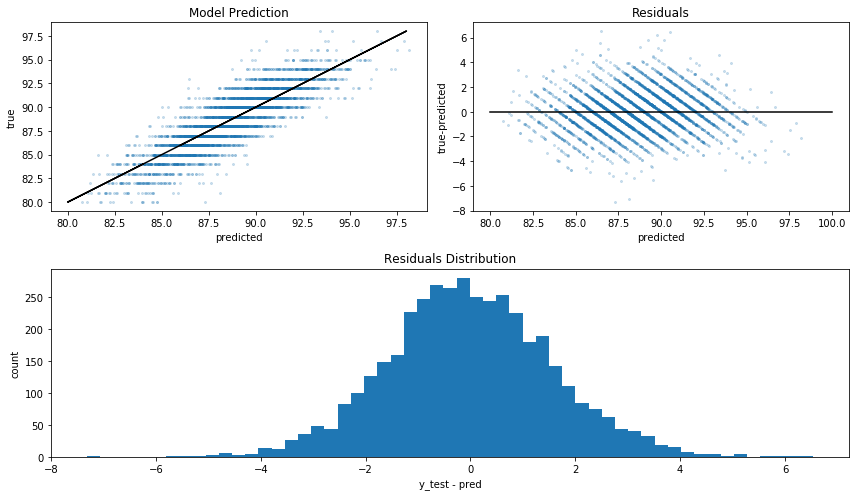

In [77]:
pred = ridge_gcv.best_estimator_.predict(X_test_s)

plt.figure(figsize=(12,7))
ax11 = plt.subplot(2, 2, 1)
ax12 = plt.subplot(2, 2, 2)
ax2 = plt.subplot(2, 1, 2)

ax11.scatter(pred, y_test, alpha=0.2, s=4)
ax11.plot(y_test, y_test, '-', c='k')
ax11.set_title("Model Prediction")
ax11.set_ylabel('true')
ax11.set_xlabel('predicted')

ax12.scatter(pred, (y_test-pred), alpha=0.2, s=4)
ax12.plot([80, 100], [0, 0], '-', c='k')
ax12.set_title("Residuals")
ax12.set_ylabel('true-predicted')
ax12.set_xlabel('predicted')

ax2.hist(y_test - pred, bins="auto")
ax2.set_title("Residuals Distribution")
ax2.set_xlabel("y_test - pred")
ax2.set_ylabel("count")

plt.tight_layout()

#ridge_gcv.best_estimator_.named_steps['columntransformer'].transformers_[1][1][1].get_feature_names

**The combined model presented the best performance in $R^2$ so far, however, the improvement is not extremely important a lot of the categorical and continuous features are somehow contained in the text features.**

In [78]:
elapsed_time = timeit.default_timer() - start_time
elapsed_time

969.0818731